# Ampliación: Métricas de Evaluación del Modelo

En este notebook ampliaremos el proyecto anterior de la **red neuronal para reconocer los dígitos 0 y 1 del conjunto MNIST**.  
El objetivo es incorporar **métricas de evaluación** que nos permitan analizar con mayor profundidad el desempeño del modelo, más allá del simple valor de precisión obtenido durante el entrenamiento.

Aprenderemos a generar e interpretar:
- La **precisión global (accuracy)**.  
- El **reporte de clasificación**, que incluye *precision*, *recall* y *F1-score* por clase.  
- La **matriz de confusión**, que visualiza los aciertos y errores del modelo.

Con ello, podremos **evaluar objetivamente la calidad de las predicciones** y entender en qué casos el modelo tiende a equivocarse.


### Importamos librerías necesarias

In [1]:
import torch                         # Manejo de tensores y operaciones con GPU
import torch.nn as nn                # Módulo para definir redes neuronales
import torch.optim as optim          # Métodos de optimización (SGD, Adam, etc.)
from torchvision import datasets, transforms  # Conjuntos de datos y transformaciones
from torch.utils.data import DataLoader       # Carga de datos por lotes (batch)
import matplotlib.pyplot as plt      # Para graficar imágenes y resultados

### Inicialización de datos de entrenamiento y prueba

In [ ]:

# Inicialización de los datos (entrenamiento y prueba)


# transforms.ToTensor()
# Convierte imágenes en tensores de PyTorch.
# Escala los píxeles de 0–255 a 0.0–1.0 y cambia el formato a (canales, alto, ancho).
transformacion = transforms.ToTensor()

# datasets.MNIST()
# Carga o descarga el conjunto de datos MNIST (dígitos 0–9).
# Devuelve pares (imagen, etiqueta).
# Argumentos:
#   root="./data"          → Carpeta donde se guardan los datos.
#   train=True/False       → Define si son datos de entrenamiento o prueba.
#   download=True          → Descarga automática si no existen.
#   transform=transformacion → Aplica la conversión a tensor.
datos_entrenamiento = datasets.MNIST(
    root="./data", train=True, download=True, transform=transformacion
)

datos_prueba = datasets.MNIST(
    root="./data", train=False, download=True, transform=transformacion
)

# Cada elemento del dataset es una tupla (imagen_tensor, etiqueta)
# Ejemplo: imagen 28x28 y etiqueta numérica entre 0 y 9.


100.0%
100.0%
100.0%
100.0%


### Máscara de datos para filtrar solo los dígitos 0 y 1

In [ ]:



# Filtrar el dataset para quedarnos solo con los dígitos 0 y 1


# Creamos una "máscara" booleana para cada conjunto:
#   True  → si la etiqueta es 0 o 1
#   False → si la etiqueta es otro número (2–9)
# Esto nos permite seleccionar solo los ejemplos que pertenecen a las clases deseadas.
mascara_entrenamiento = (datos_entrenamiento.targets == 0) | (datos_entrenamiento.targets == 1)
mascara_prueba = (datos_prueba.targets == 0) | (datos_prueba.targets == 1)

# Usamos las máscaras para filtrar los datos e índices correspondientes:
#   - .data almacena las imágenes (matrices 28x28)
#   - .targets contiene las etiquetas (número representado)
datos_entrenamiento.data = datos_entrenamiento.data[mascara_entrenamiento]
datos_entrenamiento.targets = datos_entrenamiento.targets[mascara_entrenamiento]

datos_prueba.data = datos_prueba.data[mascara_prueba]
datos_prueba.targets = datos_prueba.targets[mascara_prueba]

# Ahora ambos conjuntos contienen solo imágenes de los dígitos 0 y 1,
# lo que convierte el problema en una clasificación binaria.



### Definimos características X y etiquetas Y (sin aplanar)

In [ ]:

# Convertimos los datos a tipo flotante para poder operar con PyTorch


# .data contiene las imágenes (matrices 28x28)
# .float() convierte los valores enteros (0–255) a decimales (0.0–255.0)
X_entrenamiento = datos_entrenamiento.data.float()

# .targets contiene las etiquetas (0 o 1)
# .float() las convierte a tipo flotante, útil para operaciones numéricas posteriores
Y_entrenamiento = datos_entrenamiento.targets.float()

# .reshape((n,1)) cambia la forma del tensor a una columna
# Esto permite que Y tenga dimensión [n,1] en lugar de [n], como exige PyTorch
Y_entrenamiento = Y_entrenamiento.reshape((Y_entrenamiento.shape[0], 1))

print("Ejemplo de etiqueta:", Y_entrenamiento[0])


# Repetimos el mismo proceso para el conjunto de prueba


X_prueba = datos_prueba.data.float()
Y_prueba = datos_prueba.targets.float()
Y_prueba = Y_prueba.reshape((Y_prueba.shape[0], 1))


Ejemplo de etiqueta: tensor([0.])


### Definimos modelo, función de pérdida y optimizador

In [ ]:

# Modelo: red totalmente conectada para clasificar 0 vs 1


modelo = nn.Sequential(
    nn.Flatten(),           # Convierte imagen 1x28x28 → vector 784
    nn.Linear(28*28, 512),  # Capa oculta: 784 → 512
    nn.Sigmoid(),           # Activación (no linealidad)
    nn.Linear(512, 1),      # Capa de salida: 512 → 1 (probabilidad de clase 1)
    nn.Sigmoid()            # Mapea salida a [0,1] para clasificación binaria
)


# Función de pérdida y optimizador


fn_perdida = nn.BCELoss()                     # Binary Cross-Entropy para etiquetas {0,1}
optimizador = torch.optim.SGD(                 # Descenso por gradiente (SGD)
    modelo.parameters(), lr=0.001              # lr: tasa de aprendizaje
)

# Nota: alternativamente se puede usar nn.BCEWithLogitsLoss()
# y quitar la última Sigmoid() para mayor estabilidad numérica.


### Entrenamiento del modelo

In [ ]:

# Bucle de entrenamiento: el modelo aprende ajustando sus pesos

total_iteraciones = 30  # Número de veces que veremos todos los datos (épocas)

for i in range(total_iteraciones):

    # Forward pass: calculamos las predicciones de la red
    y_pred = modelo(X_entrenamiento)

    # Cálculo de la pérdida: mide qué tan lejos están las predicciones de las etiquetas reales
    perdida = fn_perdida(y_pred, Y_entrenamiento)

    # Reinicia los gradientes acumulados del paso anterior
    optimizador.zero_grad()

    # Backpropagation: calcula los gradientes ∂L/∂w para cada peso del modelo
    perdida.backward()

    # Actualiza los pesos según el gradiente y la tasa de aprendizaje
    optimizador.step()

    # Muestra el progreso y el valor actual de la pérdida
    print(f"Iteración {i+1}/{total_iteraciones}, Pérdida: {perdida.item():.4f}")


Iteración 1/30, Pérdida: 0.7631
Iteración 2/30, Pérdida: 0.7461
Iteración 3/30, Pérdida: 0.7299
Iteración 4/30, Pérdida: 0.7144
Iteración 5/30, Pérdida: 0.6997
Iteración 6/30, Pérdida: 0.6856
Iteración 7/30, Pérdida: 0.6721
Iteración 8/30, Pérdida: 0.6593
Iteración 9/30, Pérdida: 0.6469
Iteración 10/30, Pérdida: 0.6351
Iteración 11/30, Pérdida: 0.6238
Iteración 12/30, Pérdida: 0.6129
Iteración 13/30, Pérdida: 0.6023
Iteración 14/30, Pérdida: 0.5922
Iteración 15/30, Pérdida: 0.5825
Iteración 16/30, Pérdida: 0.5731
Iteración 17/30, Pérdida: 0.5640
Iteración 18/30, Pérdida: 0.5552
Iteración 19/30, Pérdida: 0.5467
Iteración 20/30, Pérdida: 0.5384
Iteración 21/30, Pérdida: 0.5304
Iteración 22/30, Pérdida: 0.5227
Iteración 23/30, Pérdida: 0.5151
Iteración 24/30, Pérdida: 0.5078
Iteración 25/30, Pérdida: 0.5007
Iteración 26/30, Pérdida: 0.4938
Iteración 27/30, Pérdida: 0.4871
Iteración 28/30, Pérdida: 0.4805
Iteración 29/30, Pérdida: 0.4741
Iteración 30/30, Pérdida: 0.4679


### Evaluación del modelo en datos de prueba

In [ ]:

# Evaluación del modelo: medimos qué tan bien aprendió

modelo.eval()  # Cambia el modelo a modo de evaluación (desactiva dropout, batchnorm, etc.)

# torch.no_grad() desactiva el cálculo de gradientes para ahorrar memoria y acelerar la inferencia.
with torch.no_grad():
    # Calculamos las salidas (predicciones continuas entre 0 y 1)
    salida = modelo(X_prueba)

    # Convertimos las probabilidades en etiquetas binarias:
    #   > 0.5 → clase 1,  ≤ 0.5 → clase 0
    predicciones = (salida > 0.5).float()

    # Comparamos predicciones con etiquetas verdaderas
    # .sum() cuenta cuántas predicciones son correctas
    # .item() convierte el resultado tensorial a número normal (Python float)
    correctas = (predicciones == Y_prueba).sum().item()

    # .size(0) devuelve el total de muestras evaluadas
    total = Y_prueba.size(0)

# Calculamos el porcentaje de aciertos
print(f"Precisión en prueba: {100 * correctas / total:.2f}%")


Precisión en prueba: 97.59%


### Pruebas individuales del modelo

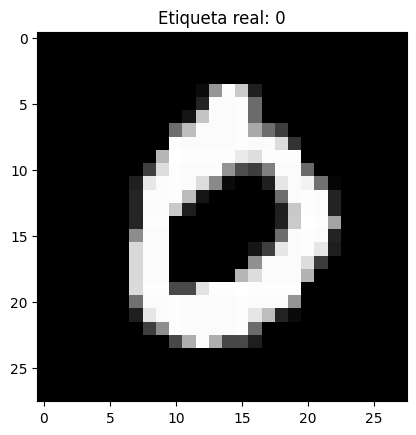

Predicción del modelo: 0


In [ ]:

# Prueba individual: verificamos la predicción para una sola imagen

# Seleccionamos una imagen del conjunto de prueba
indice = 1
imagen = X_prueba[indice]      # Tensor de la imagen seleccionada
etiqueta = Y_prueba[indice]    # Etiqueta real (0 o 1)

# Visualizamos la imagen en escala de grises
plt.imshow(imagen.reshape(28, 28), cmap='gray')    # Convertimos a 28x28 para mostrar
plt.title(f"Etiqueta real: {int(etiqueta)}")       # Mostramos la clase verdadera
plt.show()

# Evaluamos el modelo con esa imagen
modelo.eval()  # Modo evaluación (sin actualización de pesos)

with torch.no_grad():  # Sin cálculo de gradientes (ahorra memoria)
    entrada = imagen.reshape(1, 28, 28)    # Redimensionamos para simular un lote (batch=1)
    salida = modelo(entrada)               # Forward pass → salida del modelo
    prediccion = (salida > 0.5).float()    # Clasificación: 1 si probabilidad > 0.5, de lo contrario 0

# Mostramos el resultado del modelo
print(f"Predicción del modelo: {int(prediccion.item())}")


### Métricas de evaluación del modelo


Precisión (Accuracy): 97.59%

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

    Dígito 0       0.97      0.98      0.97       980
    Dígito 1       0.98      0.97      0.98      1135

    accuracy                           0.98      2115
   macro avg       0.98      0.98      0.98      2115
weighted avg       0.98      0.98      0.98      2115


--- Matriz de Confusión ---
[[ 958   22]
 [  29 1106]]


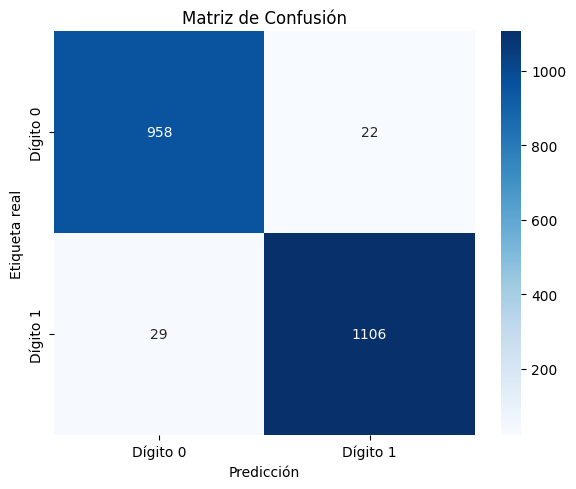

In [10]:
from sklearn.metrics import confusion_matrix, classification_report  # Métricas
import seaborn as sns              # Visualización de la matriz de confusión
import numpy as np                 # Cálculos numéricos
import matplotlib.pyplot as plt    # Gráficas
import torch                       # Tensores y control de gradientes

modelo.eval()  # Cambia el modelo a modo evaluación

# torch.no_grad(): desactiva el cálculo de gradientes durante la inferencia
with torch.no_grad():
    salida = modelo(X_prueba)               # Predicciones del modelo (probabilidades entre 0 y 1)
    predicciones = (salida > 0.5).float()   # Convierte probabilidades en clases (0 o 1)

# detach(): separa el tensor del grafo de cálculo
# cpu(): mueve los datos a CPU (necesario si se entrenó en GPU)
# numpy(): convierte el tensor a un arreglo NumPy
# ravel(): aplana el arreglo (de 2D a 1D)
y_true_np = Y_prueba.detach().cpu().numpy().ravel()
y_pred_np = predicciones.detach().cpu().numpy().ravel()

# Accuracy: porcentaje total de aciertos del modelo
# (y_pred_np == y_true_np) compara cada predicción con su valor real
# .mean() calcula el promedio de aciertos y *100 lo convierte a porcentaje
acc = (y_pred_np == y_true_np).mean() * 100
print(f"\nPrecisión (Accuracy): {acc:.2f}%\n")

# classification_report(): muestra métricas por clase
# Argumentos:
#   y_true_np → etiquetas reales
#   y_pred_np → etiquetas predichas
#   target_names → nombres de las clases para el reporte
class_names = ['Dígito 0', 'Dígito 1']
print("--- Reporte de Clasificación ---")
print(classification_report(y_true_np, y_pred_np, target_names=class_names))

# confusion_matrix(): genera una tabla con aciertos y errores
# Argumentos:
#   y_true_np → etiquetas reales
#   y_pred_np → etiquetas predichas
#   Filas: clases reales | Columnas: clases predichas
cm = confusion_matrix(y_true_np, y_pred_np)
print("\n--- Matriz de Confusión ---")
print(cm)

# Visualización con seaborn (heatmap)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()
